Nous allons utiliser la version régression du K-nn afin de prédire la qualité du vin, sur le dataset https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

Nous allons chercher le meilleur modèle en optimisant la MSE (erreur quadratique moyenne) et le R2 via une grid search.
Nous comparerons enfin les performances à l’aide d’une baseline naïve ainsi que les différentes heuristiques.

In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import dummy
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import neighbors, metrics

import warnings
warnings.filterwarnings(action='ignore')

seed = 42

# Chargement et préparation des données

In [2]:
data = pd.read_csv('winequality-red.csv', sep=";")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Nos données contiennent 12 colonnes, 11 qui correspondent à divers indicateurs physico-chimiques et 1 qui est la qualité du vin.

Nous allons extraire deux arrays numpy de ces données, un qui contient les points et l’autre qui contient les étiquettes :

In [3]:
X = data.as_matrix(data.columns[:-1])
y_m = data.as_matrix([data.columns[-1]])
y = y_m.flatten()

On peut maintenant afficher un histogramme pour chacune de nos variables :

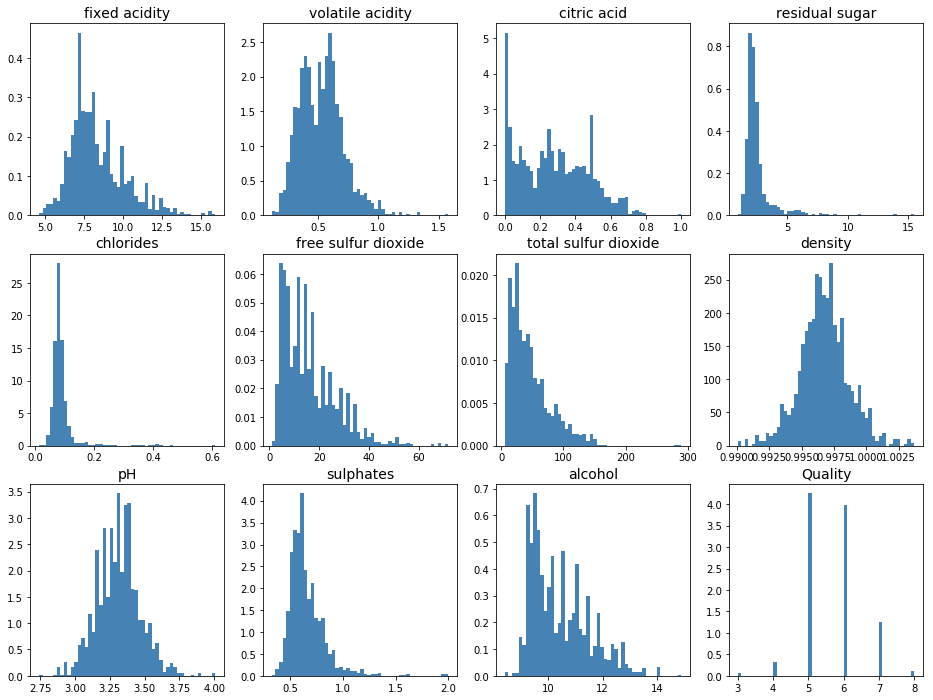

In [4]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue',
                normed=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

ax = fig.add_subplot(3,4, 12)
h = ax.hist(y, bins=50, color='steelblue',
            normed=True, edgecolor='none')
ax.set_title('Quality', fontsize=14)
plt.show()

On remarque en particulier que ces variables prennent des valeurs dans des ensembles différents. Par exemple, “alcohol” varie de 0 à 0.6 tandis que “density” varie de 0 à 120. Il va donc nous falloir standardiser les données pour que la deuxième ne domine pas complètement la première.

Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 30% des données.
On paramètre 'random_state' avec la valeur du seed pour que la séparation des données soit fixe et reproductible.

In [5]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                    test_size=0.3, # 30% des données dans le jeu de test
                                     random_state = seed
                                    )

Nous pouvons maintenant standardiser les données d’entraînement et appliquer la même transformation aux données de test :

In [6]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

#  Sélection de modèles avec une Grid Search

On commence par créer la fonction qui va effectuer la validation croisée :

In [7]:
def cvf(X, y, n_neighbors, n_fold, weights, verbose=False):
    """
    X : données
    y : valeur à prédire 
    n_neighbors : liste des K à tester pour le K-NN
    n_fold : nombre de folds à créer
    weights : fonction de poids utilisée pour la prédiction
    verbose : False par défaut, permet d'afficher dees informations du code
    """
    
    # on recrée les folds. Etant donné que pour l'exercice on va utiliser n_fold = 5 comme dans la partie 1,
    # et qu'on utilise la même seed, on aura les mêmes folds que dans la partie 1.
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=seed)
    if verbose: 
        for train_index, test_index in kf.split(X):
            print("TRAIN:", "taille", len(train_index), ", 5ers indices", train_index[0:5], 
                  "|| TEST:", "taille", len(test_index), ", 5ers indices", test_index[0:5])
    
    # on initialise les listes qui contiendront les différents résultats de MSE et R2
    MSE = [] 
    R2 = []
    
    # on boucle pour tester les différentes valeurs de K pour le KNN
    for kn in n_neighbors:
        if verbose: print("kn", kn)    
        knn = neighbors.KNeighborsRegressor(kn, weights=weights) # initialisation du classifieur
        
        MSE_fold = [] # initialisation d'une liste qui contiendra la MSE pour chaque k-fold et chaque knn
        R2_fold = []
        
        # on boucle sur les différents folds
        for train_index, test_index in kf.split(X):
            if verbose: print("TRAIN:", "taille", len(train_index), ", 5ers indices", train_index[0:5], 
                      "|| TEST:", "taille", len(test_index), ", 5ers indices", test_index[0:5])
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
                        
            # on fit le knn sur le fold d'entrainement
            knn.fit(X_train, y_train)
            
            # on calcule les y prédits sur le fold de test
            y_pred = knn.predict(X_test)
            
            # on calcule le MSE et le R2 sur le fold de test et on l'ajoute aux listes :
            #accuracy_fold.append([knn.score(X_train_std_test, y_train_test)])
            MSE_fold.append([metrics.mean_squared_error(y_test, y_pred)])
            R2_fold.append([knn.score(X_test, y_test)])
            
        if verbose: 
            print(np.mean(MSE_fold))
            print(np.mean(R2_fold))
        
        # on aggrège les résultats en ne gardant que la moyenne des accuracy des différents folds pour chaque k
        #accuracy.append([kn, round(np.mean(accuracy_fold), 3)])
        MSE.append([kn, round(np.mean(MSE_fold), 3)])
        R2.append([kn, round(np.mean(R2_fold), 3)])
    
    return MSE, R2           

On fait tourner notre fonction avec les hyper-paramètres que nous souhaitons tester. Ici il est demandé de tester le nombre de voisins, mais nous allons également comparer les résultats avec 2 fonctions de poids différentes pour la prédiction ('uniform' et 'distance'). 

Commençons avec la fonction de poids 'uniform' :

In [8]:
n_neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]
weights='uniform'
n_fold = 5

cvf_unif = cvf(X_train_std, y_train, n_neighbors, n_fold, weights, verbose=False)

On concatène les résultats pour mieux les observer :

In [9]:
MSE_unif = pd.DataFrame(cvf_unif[0], columns=['k', 'MSE'])
R2_unif = pd.DataFrame(cvf_unif[1], columns=['k', 'R2'])
results_unif = MSE_unif.merge(R2_unif, on='k')
results_unif

,k,MSE,R2
0,3,0.521,0.199
1,5,0.494,0.239
2,7,0.486,0.252
3,9,0.472,0.275
4,11,0.461,0.292
5,13,0.457,0.299
6,15,0.455,0.302
7,17,0.453,0.305
8,19,0.449,0.311
9,21,0.448,0.313


La MSE semble être la plus faible lorsque k = 39.
LE R2 semble évoluer de façon inverse à la MSE (le R2 atteint son maximum lorsque la MSE atteint son minimum).

Observons cela sur un graphique :

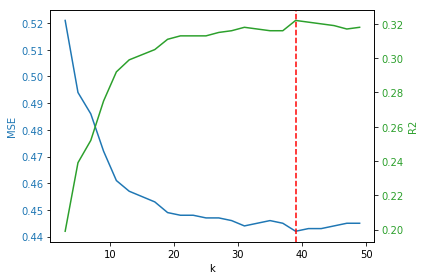

In [10]:
x = results_unif['k']
y1 = results_unif['MSE']
y2 = results_unif['R2']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('k')
ax1.set_ylabel('MSE', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('R2', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.axvline(39, color='red', linestyle='--')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

La ligne rouge correspond marque la position où le MSE est minimum et le R2 maximum.

Regardons maintenant ce qu'il se passe avec la fonction de poids 'distance' :

In [11]:
n_neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]
weights = 'distance'
n_fold = 5

cvf_dist = cvf(X_train_std, y_train, n_neighbors, n_fold, weights, verbose=False)

On concatène les résultats pour mieux les observer :


In [12]:
MSE_dist = pd.DataFrame(cvf_dist[0], columns=['k', 'MSE'])
R2_dist = pd.DataFrame(cvf_dist[1], columns=['k', 'R2'])
results_dist = MSE_unif.merge(R2_dist, on='k')
results_dist

,k,MSE,R2
0,3,0.521,0.283
1,5,0.494,0.337
2,7,0.486,0.355
3,9,0.472,0.371
4,11,0.461,0.387
5,13,0.457,0.394
6,15,0.455,0.396
7,17,0.453,0.398
8,19,0.449,0.403
9,21,0.448,0.406


La MSE semble être la plus faible lorsque k = 39, ce qui est cohérent avec nos précédents résultats.
LE R2 semble évoluer de façon inverse à la MSE (le R2 atteint son maximum lorsque la MSE atteint son minimum).

Observons cela sur un graphique :

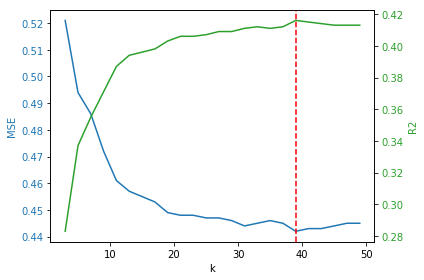

In [13]:
x = results_dist['k']
y1 = results_dist['MSE']
y2 = results_dist['R2']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('k')
ax1.set_ylabel('MSE', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('R2', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.axvline(39, color='red', linestyle='--')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

De la même façon que tout à l'heure, la ligne rouge correspond à la position où le MSE est minimun et le R2 maximum. 

Nous allons donc retenir le modèle avec les 39 plus proches voisins.
Entrainons donc un knn avec k = 39 sur les données d'entrainements :

In [14]:
knn39 = neighbors.KNeighborsRegressor(n_neighbors=39)
knn39.fit(X_train_std, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=39, p=2,
          weights='uniform')

Et appliquons le pour prédire les étiquettes de notre jeu de test, et la RMSE correspondante :

In [15]:
y_pred = knn39.predict(X_test_std)
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.66


Nos étiquettes étant des nombres entiers, nous faisons en moyenne une erreur inférieure à la plus petite différence possible entre deux notes.

Nous pouvons visualiser les résultats sur un graphique, en représentant en abscisse les vraies valeurs des étiquettes, et en ordonnée les valeurs prédites.
Comme nos étiquettes prennent des valeurs entières entre 3 et 8, nous avons beaucoup de points superposés aux même coordonnées. Pour mieux visualiser les données, nous pouvons utiliser un swarplot qui va étaler les points positionnés aux mêmes valeurs de x pour les rendre visibles :

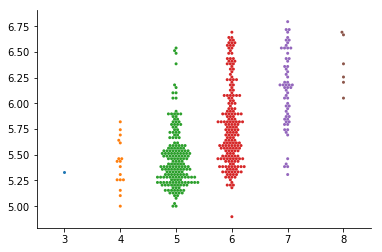

In [16]:
sns.swarmplot(y_test, y_pred, size=3)
sns.despine()

On remarque que les notes extrêmes (3, 4, 8) sont mal prédites. Le modèle n'est pas très précis dans ses prédictions.

Pour mieux comprendre notre modèle, comparons-le à une première approche naïve, qui consiste à prédire des valeurs aléatoires, distribuées uniformément entre les valeurs basse et haute des étiquettes du jeu de données d'entraînement.

In [17]:
y_pred_random = np.random.randint(np.min(y), np.max(y), y_test.size)

Calculons la RMSE correspondante :

In [18]:
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_random)))

RMSE : 1.71


Nous obtenons une RMSE de 1.74, ce qui est bien supérieur à la RMSE obtenue par notre modèle kNN. Notre modèle a ainsi réussi à bien mieux apprendre qu'un modèle aléatoire.

Cependant, beaucoup de nos vins ont une note de 5 et 6, et beaucoup de nos prédictions sont autour de cette valeur. Comparons maintenant notre modèle à un modèle aléatoire qui retourne systématiquement la valeur moyenne des étiquettes du jeu de données d'entraînement.

Nous pouvons utiliser pour cela la fonction correspondante du module "dummy" de scikit-learn :

In [19]:
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_train_std, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)

# Evaluate
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum)))

RMSE : 0.80


nous obtenons une RMSE de 0.80, qui est supérieure à celle de 0.66 obtenue par le kNN. Le kNN a donc appris plus que la moyenne des étiquettes.